# Mass-spring-damper system estimation via Kalman Filter

[<img src="Mass_spring_damper.png" width="250"/>](Mass_spring_damper.png)

In [1]:
import symforce.symbolic as sf
import matplotlib.pyplot as plt
import numpy as np

from symforce.notebook_util import display
# %matplotlib inline

# Developing the Equations of Motion

In [2]:
# Governing Equation
# m * a + c * v + k * x = f
# v = dx/dt;  a = dv/dt

# STATE 
# q = [x]
#     [v]

# STATE DERIVATIVE
# qdot = [v]
#        [a]

# PLUG THINGS IN
# qdot = [q1],
#         [a]

# a = (f - k * x - c * v) / m
# a = (f - k * q0 - c * q1)/ m

# qdot = [q1]
#        [f - k*q0 - c*q1]

# LINEAR SYSTEM:
# qdot =  [ 1    0]   @  [q0]  +  [ 0 ] @ f
#         [-k/m -c/m]    [q1]     [1/m]

## Or... we do this with symforce

In [3]:
x, v, a, f, m, k, c = sf.symbols('x v a f m k c')

q = sf.V2(x, v)
qdot = sf.V2(v,a)
qdot = qdot.subs(a, (f - k * x - c * v) / m)

A = qdot.jacobian(q)
B = qdot.jacobian(f)

print("A = ")
display(A)

print("B = ")
display(B)


A = 


⎡ 0    1 ⎤
⎢        ⎥
⎢-k   -c ⎥
⎢───  ───⎥
⎣ m    m ⎦

B = 


⎡0⎤
⎢ ⎥
⎢1⎥
⎢─⎥
⎣m⎦

# First Task:
We want to create a simulation of the mass-spring-damper system: <br>
Complete the following code:



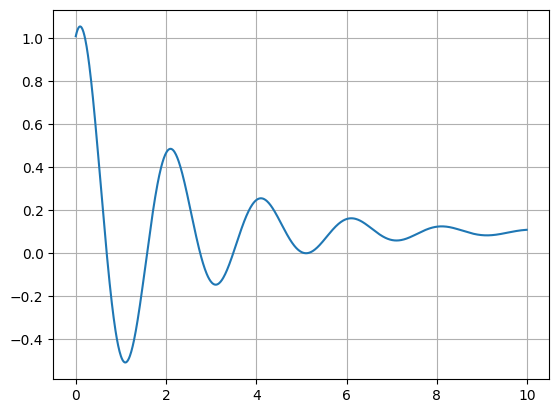

In [4]:
#INITALIZE
m = 1.0
k = 10.0
c = 1.0

#State Space
A = np.array([[0, 1],
             [-k/m, -c/m]])
B = np.array([[0],
             [1/m]])

#Time Vector
t_0 = 0
dt = 0.01
t_final = 10
t_vec =  np.arange(t_0, t_final, dt)

#constant force
f = 1.0

#initial state
q = np.array([1,1]).reshape(-1,1) 

history = {'x': []}
#SIMULATION
for t in t_vec:
    #------------YOUR CODE HERE------------------#
    #compute qdot, q (you can use euler integration y_(k+1) = y_k + dx * y'_k)
    qdot = A @ q + B * f
    q = q + qdot * dt
    #------------YOUR CODE HERE------------------#
    
    #save position measurement
    history['x'].append(q[0])

#PLOT
plt.figure()
plt.plot(t_vec, history['x'])
plt.grid(True)
plt.show()

# Second Task
We want to add noisy position measurement and noisy force </br>
h(x) ~ Normal (mu = x, std = 0.05) </br>
f ~ Normal (mu = 1, std = 3) </br>
</br>

complete the following code: </br>
you can use: </br> 
np.random.normal(mu,std)

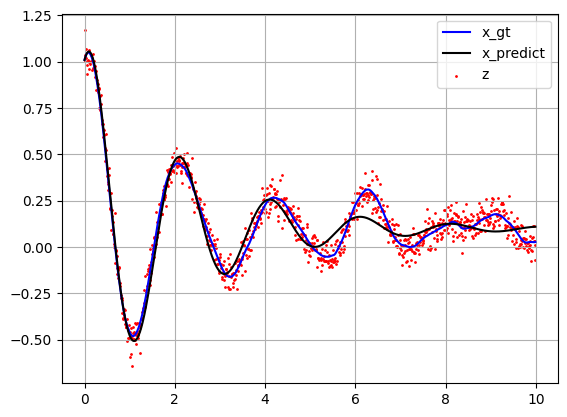

In [5]:
#INITALIZE
m = 1.0
k = 10.0
c = 1.0

#State Space
A = np.array([[0, 1],
             [-k/m, -c/m]])
B = np.array([[0],
             [1/m]])

#Time Vector
t_0 = 0.0
dt = 0.01
t_final = 10
t_vec =  np.arange(t_0, t_final, dt)

#constant force
f_nominal = 1.0

#inital state
q_gt = np.array([1,1]).reshape(-1,1)
q_predict = np.array([1,1]).reshape(-1,1)

history = {'x_gt': [], 'x_predict': [], 'z': []}
#SIMULATION
for t in t_vec:
    #------------YOUR CODE HERE------------------#
    #compute f_real from f_nominal
    f_real = np.random.normal(f_nominal,3)
    
    #compute q_gt with euler integration using f_real
    qdot_gt = A @ q_gt + B * f_real
    q_gt = q_gt + qdot_gt * dt

    #compute compute q_predict with euler integration using f_nominal
    qdot_predict = A @ q_predict + B * f_nominal
    q_predict = q_predict + qdot_predict * dt

    #compute z using q_gt 
    z = np.random.normal(q_gt[0],0.05)
    #------------YOUR CODE HERE------------------#

    history['x_gt'].append(q_gt[0])
    history['x_predict'].append(q_predict[0])
    history['z'].append(z)

#PLOT
plt.figure()
plt.plot(t_vec, history['x_gt'], color = 'blue')
plt.plot(t_vec, history['x_predict'], color = 'black')
plt.scatter(t_vec, history['z'], s = 1, color = 'red')
plt.legend(['x_gt', 'x_predict', 'z'])
plt.grid(True)
plt.show()

# Third Task

Estiamte the position using a Kalman Filter </br>
Complete the following code:

In [10]:
#INITALIZE
m = 1.0
k = 10.0
c = 1.0

#State Space
A = np.array([[0, 1],
             [-k/m, -c/m]])
B = np.array([[0],
             [1/m]])

#Time Vector
t_0 = 0.0
dt = 0.01
t_final = 10
t_vec =  np.arange(t_0, t_final, dt)


#KALMAN PARAMTERS - c2d #https://en.wikipedia.org/wiki/Discretization
I = np.eye(2)
A_D = (I + A * dt)
B_D = np.linalg.inv(A) @ (A_D - I) @ B

H = np.array([[1.0, 0]])
COV_R = np.diag([0.5*(3/m)*dt**2, 0.5*(3/m)*dt])
COV_Q = np.array([[0.05**2]])
COV_PRIOR = np.eye(2) * 1e-15

#constant force
f_nominal = 1.0

#inital state
q_gt = np.array([1,1]).reshape(-1,1)
q_est_mu = np.array([1,1]).reshape(-1,1)
q_est_cov = COV_PRIOR


def kalman(q_prev, cov_prev, f, z):
    #------------YOUR CODE HERE------------------#
    #compute mu, cov, K
    #You can use Probablistic Robotics page 36
        #Use the A_D, B_D, H, COV_R, COV_Q and I in your solution

    #predict
    mu_bar = A_D @ q_prev + B_D * f
    cov_bar = A_D @ cov_prev @ A_D.T + COV_R
    
    #update
    K = cov_bar @ H.T @ np.linalg.inv(H @ cov_bar @ H.T + COV_Q)
    mu = mu_bar + K @ (z - H @ mu_bar)
    cov = (I - K @ H) @ cov_bar
    #------------YOUR CODE HERE------------------#
    return mu, cov, K

history = {'x_gt': [],
            'x_est': [],
            'x_est_std': [],
            'z': [],
            'K': [],
            }
#SIMULATION
np.random.seed(1)
for t in t_vec:
    f_real = np.random.normal(f_nominal,3)
    q_gt = A_D @ q_gt + B_D * f_real
    z = np.random.normal(q_gt[0],0.05)

    q_est_mu, q_est_cov, K = kalman(q_est_mu, q_est_cov ,f_nominal ,z)

    history['x_gt'].append(q_gt[0,0])
    history['x_est'].append(q_est_mu[0,0])
    history['x_est_std'].append(np.sqrt(q_est_cov[0,0]))
    history['z'].append(z)
    history['K'].append(K)

#PLOT
# %matplotlib inline
%matplotlib auto

plt.figure()
graphics_est, = plt.plot(t_vec, history['x_est'], color = 'black')
graphics_z = plt.scatter(t_vec, history['z'], s = 1, color = 'red')
graphics_gt, = plt.plot(t_vec, history['x_gt'], color = 'blue')
grpahics_K0, = plt.plot(t_vec,[K[0,0] for K in history['K']], color = 'green')
grpahics_K1, = plt.plot(t_vec,[K[1,0] for K in history['K']], color = 'yellow')
plt.legend([graphics_gt, graphics_est, graphics_z, grpahics_K0, grpahics_K1], ['x_gt', 'x_est', 'z', 'K[0]', 'K[1]'])
plt.title('kalman filter')
plt.show()
plt.grid(True)


Using matplotlib backend: TkAgg
